## WeGo Data Introduction

In [2]:
import pandas as pd

In [3]:
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,8/1/23,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,8/1/23,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [4]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.  
**3:** West End  
**7:** Hillsboro  
**22:** Bordeaux  
**23:** Dickerson Pike  
**50:** Charlotte Pike  
**52:** Nolensville Pike  
**55:** Murfreesboro Pike  
**56:** Gallatin Pike

In [6]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.  
**Warning:** The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple **time points** for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0. 

Here is the first trip in the dataset. It was a Bordeaux route (Route 22), scheduled to start at 4:42:00 and end at 5:10:00.

In [8]:
wego[['DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']].loc[:3]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,8/1/23,120230801,345104,22,MHSP,1,8/1/23 4:42
1,8/1/23,120230801,345104,22,ELIZ,0,8/1/23 4:46
2,8/1/23,120230801,345104,22,CV23,0,8/1/23 4:54
3,8/1/23,120230801,345104,22,MCC5_10,2,8/1/23 5:10


Note that the same TRIP_ID appears on the following day.

In [10]:
(
    wego
    .loc[wego['DATE'].astype(str).isin(['2023-08-01', '2023-08-02'])]
    .loc[wego['TRIP_ID'] == 345104]
    [['DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'ROUTE_DIRECTION_NAME', 'SCHEDULED_TIME', 'ROUTE_STOP_SEQUENCE']]
)

,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,TRIP_EDGE,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,ROUTE_STOP_SEQUENCE


**Adherence** refers to the difference between scheduled time and the actual time that the bus departs from a stop.

A negative value for ADHERENCE indicates that the bus is late, and a positive indicates that the bus is early.

Generally, an adherence value less than -6 is considered late, and greater than 1 is considered early, but there are some exceptions. For example, a positive adherence for the end of a trip (TRIP_EDGE 2) is not considered early, since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. You can check whether a trip was considered on-time, early, or late using the ADJUSTED_EARLY_COUNT, ADJUSTED_LATE_COUNT, and ADJUSTED_ONTIME_COUNT columns.

Here is an example of a trip where all time points would be considered to be on time. Notice that at the end of the trip, the bus was more than 6 minutes early, but was still counted as on-time since this was a trip edge of 2.

In [12]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[:3]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,8/1/23,120230801,345104,22,MHSP,1,8/1/23 4:42,8/1/23 4:44,-2.133333,0,0,1
1,8/1/23,120230801,345104,22,ELIZ,0,8/1/23 4:46,8/1/23 4:48,-2.450000,0,0,1
2,8/1/23,120230801,345104,22,CV23,0,8/1/23 4:54,8/1/23 4:54,-0.933333,0,0,1
3,8/1/23,120230801,345104,22,MCC5_10,2,8/1/23 5:10,8/1/23 5:03,6.283333,0,0,1


And one that has one late stop.

In [14]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[77:79]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
77,8/1/23,120230801,345127,22,MHSP,1,8/1/23 17:05,8/1/23 17:08,-3.350000,0,0,1
78,8/1/23,120230801,345127,22,CV23,0,8/1/23 17:14,8/1/23 17:20,-6.166666,0,1,0
79,8/1/23,120230801,345127,22,MCC5_10,2,8/1/23 17:30,8/1/23 17:30,-0.383333,0,0,1


And one which was early.

In [16]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[11:13]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
11,8/1/23,120230801,345107,22,MCC5_10,1,8/1/23 6:15,8/1/23 6:16,-1.316666,0,0,1
12,8/1/23,120230801,345107,22,CV23,0,8/1/23 6:25,8/1/23 6:23,1.500000,1,0,0
13,8/1/23,120230801,345107,22,MHSP,2,8/1/23 6:35,8/1/23 6:30,4.016666,0,0,1


**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [18]:
(
    wego
    .loc[wego['ROUTE_ABBR'] == 22]
    .loc[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']
    .loc[wego['TIME_POINT_ABBR'] == 'CV23']
    [['DATE', 'TRIP_ID', 'TIME_POINT_ABBR','ROUTE_DIRECTION_NAME', 'TRIP_EDGE', 
      'SCHEDULED_TIME', 'SCHEDULED_HDWY',
      'ACTUAL_DEPARTURE_TIME', 'ACTUAL_HDWY', 'HDWY_DEV'
     ]]
    .sort_values(['DATE', 'SCHEDULED_TIME'])
    .iloc[:5]
)

,DATE,TRIP_ID,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,TRIP_EDGE,SCHEDULED_TIME,SCHEDULED_HDWY,ACTUAL_DEPARTURE_TIME,ACTUAL_HDWY,HDWY_DEV
227,8/1/23,345297,CV23,TO DOWNTOWN,0,8/1/23 10:09,10.0,8/1/23 10:09,8.866666,-1.133334
432,8/1/23,345415,CV23,TO DOWNTOWN,0,8/1/23 10:22,13.0,8/1/23 10:22,13.300000,0.300000
164,8/1/23,345223,CV23,TO DOWNTOWN,0,8/1/23 10:34,12.0,NaN,NaN,NaN
346,8/1/23,345387,CV23,TO DOWNTOWN,0,8/1/23 10:47,13.0,8/1/23 10:49,26.783333,13.783333
43,8/1/23,345116,CV23,TO DOWNTOWN,0,8/1/23 10:59,12.0,8/1/23 11:00,11.133333,-0.866667


Two other columns that you've been asked to explore are the DWELL_IN_MINS column and SCHEDULED_LAYOVER_MINUTES, which shows the difference between actual arrival and actual departure time at a time point and the time a bus was scheduled to arrive at the time point and when it is scheduled to leave at the beginning of a trip.

Here, we can see the end of the first trip in the dataset and the beginning of the next trip, which goes in the opposite direction.

In [20]:
wego.loc[3:4, ['DATE', 'TRIP_ID', 'TRIP_EDGE', 'TIME_POINT_ABBR',
               'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES']]

,DATE,TRIP_ID,TRIP_EDGE,TIME_POINT_ABBR,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
3,8/1/23,345104,2,MCC5_10,8/1/23 5:03,8/1/23 5:03,0.000000,NaN
4,8/1/23,345105,1,MCC5_10,8/1/23 5:03,8/1/23 5:16,12.866666,5.0


In [21]:
type('date')

str

In [22]:
import datetime

In [23]:
wego['DATE'] = pd.to_datetime(wego['DATE'], format = '%m/%d/%y')

In [24]:
wego['DAY'] = wego['DATE'].dt.day_name()

In [25]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,DAY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,6.500000,NaN,Tuesday
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,0.000000,NaN,Tuesday
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,0.000000,NaN,Tuesday
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,0,0,1,0,NaN,0,0.000000,NaN,Tuesday
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,0,0,1,0,0.0,0,12.866666,5.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,5.266666,0,1,0,0,0.0,0,0.000000,NaN,Saturday
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,0,1,0,0,NaN,0,0.000000,NaN,Saturday
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,1.866666,0,0,1,0,0.0,0,0.000000,NaN,Saturday
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,17.500000,0,1,0,0,0.0,0,0.000000,NaN,Saturday


In [26]:
#Get the total reported stops by day
total_count = wego['DAY'].value_counts().reset_index()
total_count

,DAY,count
0,Wednesday,58527
1,Friday,58473
2,Thursday,58456
3,Tuesday,58432
4,Monday,49116
5,Saturday,37497
6,Sunday,29828


In [27]:
#Get all of the reported on-time stops by day
on_time = wego.groupby('DAY')['ADJUSTED_ONTIME_COUNT'].sum().reset_index().sort_values(by='ADJUSTED_ONTIME_COUNT', ascending = False)
on_time

,DAY,ADJUSTED_ONTIME_COUNT
5,Tuesday,45502
6,Wednesday,45009
4,Thursday,44030
0,Friday,41973
1,Monday,40319
2,Saturday,28962
3,Sunday,24253


In [28]:
#Get all of the reported early stops by day
early_time = wego.groupby('DAY')['ADJUSTED_EARLY_COUNT'].sum().reset_index().sort_values(by='ADJUSTED_EARLY_COUNT', ascending = False)
early_time

,DAY,ADJUSTED_EARLY_COUNT
5,Tuesday,1685
1,Monday,1665
6,Wednesday,1635
4,Thursday,1570
0,Friday,1552
3,Sunday,847
2,Saturday,821


In [29]:
#Get all of the reported late stops by day
late_time = wego.groupby('DAY')['ADJUSTED_LATE_COUNT'].sum().reset_index().sort_values(by='ADJUSTED_LATE_COUNT', ascending = False)
late_time

,DAY,ADJUSTED_LATE_COUNT
0,Friday,12389
4,Thursday,10667
6,Wednesday,10297
5,Tuesday,9587
2,Saturday,6747
1,Monday,6005
3,Sunday,3346


In [111]:
merged_days = pd.merge(total_count, on_time, on='DAY')
merged_days['percent_on_time'] = merged_days['ADJUSTED_ONTIME_COUNT']/merged_days['count'] * 100
merged_days.sort_values(by= 'percent_on_time', ascending = False)

sorted_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_days['DAY'] = pd.Categorical(merged_days['DAY'], sorted_weekdays)
merged_days = merged_days.sort_values('DAY')

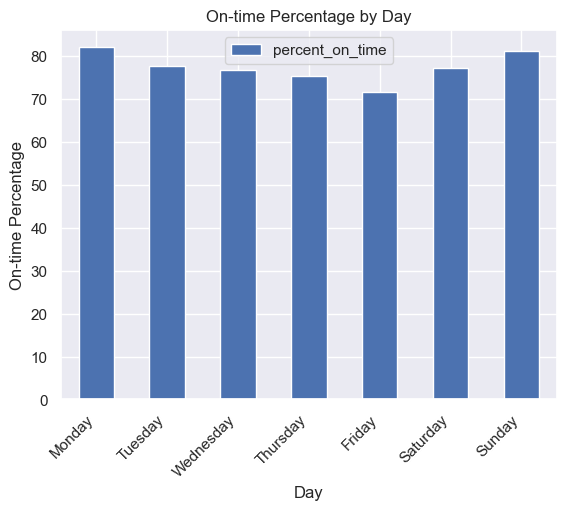

In [117]:
merged_days.plot.bar(x = 'DAY', y = 'percent_on_time')
plt.title('On-time Percentage by Day')
plt.xlabel('Day')
plt.ylabel('On-time Percentage')
plt.xticks(rotation = 45, ha = 'right');

In [119]:
merged_day_times = total_count.merge(on_time, on='DAY', how='outer') \
                .merge(early_time, on='DAY', how='outer') \
                .merge(late_time, on='DAY', how='outer')
merged_day_times['percent_on_time'] = merged_day_times['ADJUSTED_ONTIME_COUNT']/merged_day_times['count'] * 100
merged_day_times['percent_early'] = merged_day_times['ADJUSTED_EARLY_COUNT']/merged_day_times['count'] * 100
merged_day_times['percent_late'] = merged_day_times['ADJUSTED_LATE_COUNT']/merged_day_times['count'] * 100

sorted_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_day_times['DAY'] = pd.Categorical(merged_day_times['DAY'], sorted_weekdays)
merged_day_times = merged_day_times.sort_values('DAY')

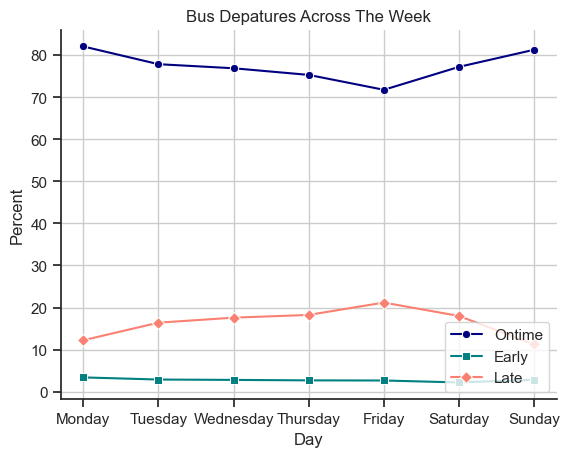

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
df = merged_day_times
 
# Set the style and font sizes
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})
 
# Create a Seaborn line plot with different markers for each product
sns.lineplot(x='DAY', y='percent_on_time', data=df, marker='o', color='navy', label='Ontime')
sns.lineplot(x='DAY', y='percent_early', data=df, marker='s', color='teal', label='Early')
sns.lineplot(x='DAY', y='percent_late', data=df, marker='D', color='salmon', label='Late')
 
# Set plot title and axes labels
plt.title('Bus Depatures Across The Week')
plt.xlabel('Day')
plt.ylabel('Percent')
 
# Add a legend
plt.legend(loc='lower right')
 
# Add a grid
plt.grid(True)
 
# Remove the top and right spines
sns.despine()
 
# Show the plot
plt.show()

In [33]:
merged_day_times.to_csv('merged_day_times.csv')

In [34]:
wego['SCHEDULED_TIME']= pd.to_datetime(wego['SCHEDULED_TIME'])
wego['TIME'] = wego['SCHEDULED_TIME'].dt.time
wego['HOUR'] = wego['SCHEDULED_TIME'].dt.hour

/var/folders/pp/vy1cm1td64l94kkzc518f7jh0000gq/T/ipykernel_92866/2548744900.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wego['SCHEDULED_TIME']= pd.to_datetime(wego['SCHEDULED_TIME'])


In [35]:
wego['TIME']

0         04:42:00
1         04:46:00
2         04:54:00
3         05:10:00
4         05:15:00
            ...   
350324    22:23:00
350325    22:38:00
350326    22:45:00
350327    22:59:00
350328    23:11:00
Name: TIME, Length: 350329, dtype: object

In [36]:
wego['HOUR']

0          4
1          4
2          4
3          5
4          5
          ..
350324    22
350325    22
350326    22
350327    22
350328    23
Name: HOUR, Length: 350329, dtype: int32

In [37]:
total_by_hour = wego['HOUR'].value_counts().reset_index()
total_by_hour

,HOUR,count
0,15,22855
1,7,22732
2,16,22657
3,17,21762
4,8,21273
5,14,21154
6,9,20815
7,12,20710
8,13,20558
9,10,20489


In [38]:
on_time_hour = wego.groupby('HOUR')['ADJUSTED_ONTIME_COUNT'].sum().reset_index().sort_values(by='ADJUSTED_ONTIME_COUNT', ascending = False)
on_time_hour

,HOUR,ADJUSTED_ONTIME_COUNT
5,7,17824
4,6,17359
8,10,17100
9,11,17098
7,9,16922
10,12,16736
11,13,16615
12,14,16177
13,15,15921
6,8,15603


In [39]:
merged_hours = pd.merge(total_by_hour, on_time_hour, on='HOUR')
merged_hours['percent_on_time'] = merged_hours['ADJUSTED_ONTIME_COUNT']/merged_hours['count'] * 100
merged_hours.sort_values(by='percent_on_time', ascending=False)

,HOUR,count,ADJUSTED_ONTIME_COUNT,percent_on_time
20,4,1724,1581,91.705336
17,5,10466,9283,88.696732
11,6,19980,17359,86.881882
10,11,20418,17098,83.739837
9,10,20489,17100,83.459417
16,22,11643,9492,81.525380
6,9,20815,16922,81.297141
8,13,20558,16615,80.820119
7,12,20710,16736,80.811202
15,21,12338,9917,80.377695


In [40]:
merged_hours = pd.merge(total_by_hour, on_time_hour, on='HOUR')
merged_hours['percent_on_time'] = merged_hours['ADJUSTED_ONTIME_COUNT']/merged_hours['count'] * 100
merged_hours.sort_values(by='HOUR', ascending=True)

,HOUR,count,ADJUSTED_ONTIME_COUNT,percent_on_time
19,0,4221,2871,68.017058
21,1,123,57,46.341463
20,4,1724,1581,91.705336
17,5,10466,9283,88.696732
11,6,19980,17359,86.881882
1,7,22732,17824,78.409291
4,8,21273,15603,73.346496
6,9,20815,16922,81.297141
9,10,20489,17100,83.459417
10,11,20418,17098,83.739837


In [41]:
import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

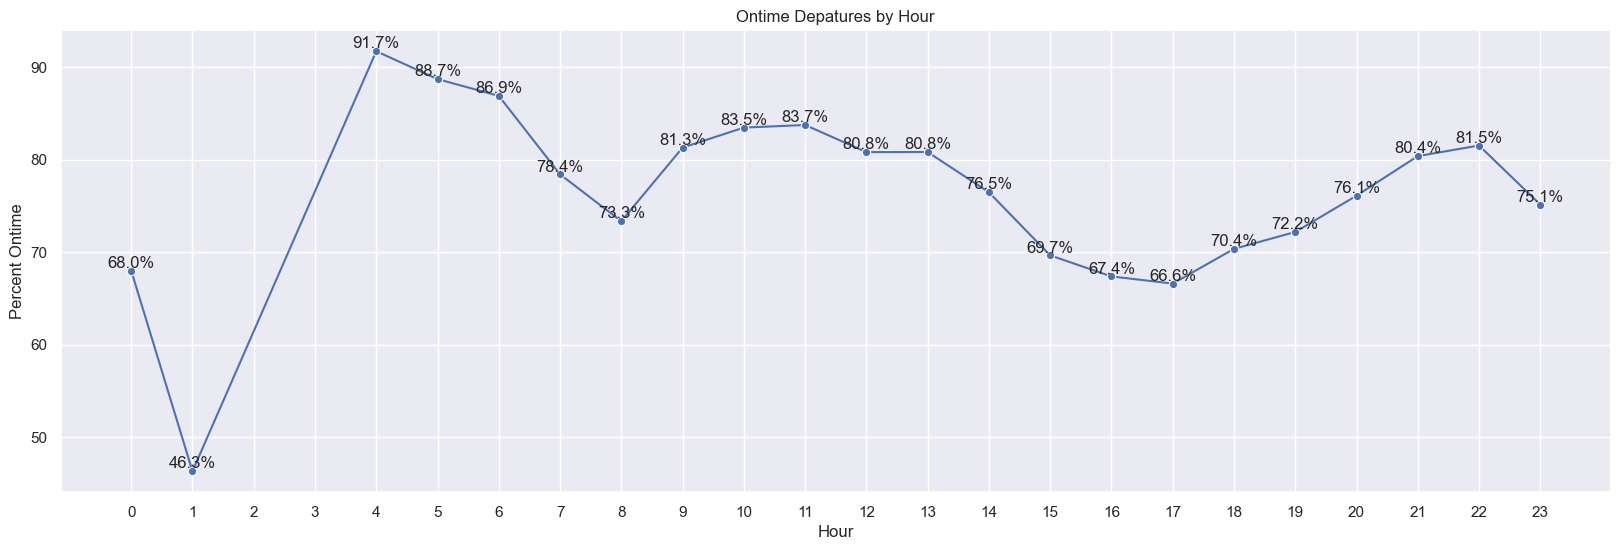

In [107]:
plt.figure(figsize=(20, 6)) # Width and Height of the chart
sns.lineplot(x='HOUR',
             y='percent_on_time',
             data=merged_hours,
             marker='o', # Style used to mark the join between 2 points
            )
plt.xlabel('Hour') # x-axis name
plt.ylabel('Percent Ontime') # y-axis name
plt.title('Ontime Depatures by Hour') # Add a title
plt.xticks(range(24))

for i, row in merged_hours.iterrows():
    plt.text(row['HOUR'], row['percent_on_time'], f'{row["percent_on_time"]:.1f}%', 
             ha='center', va='bottom')

plt.show() # Display the graph

In [77]:
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,DAY,TIME,HOUR
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,6.500000,NaN,Tuesday,04:42:00,4
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,Tuesday,04:46:00,4
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,Tuesday,04:54:00,4
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,NaN,0,0.000000,NaN,Tuesday,05:10:00,5
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,0,1,0,0.0,0,12.866666,5.0,Tuesday,05:15:00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,0.0,0,0.000000,NaN,Saturday,22:23:00,22
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,1,0,0,NaN,0,0.000000,NaN,Saturday,22:38:00,22
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,1,0,0.0,0,0.000000,NaN,Saturday,22:45:00,22
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,1,0,0,0.0,0,0.000000,NaN,Saturday,22:59:00,22


In [103]:
wegohdt_per['hdwy_dev'] = wegohdt_per['hdwy_dev'].fillna(123456)
wegohdt_per

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
350324    17.555553
350325          NaN
350326     6.222220
350327    58.333333
350328          NaN
Name: HDWY_DEV_PERC, Length: 350329, dtype: float64

In [127]:
wegohdwy = (
    wego[['DATE','DAY', 'TIME', 'HOUR', 'ACTUAL_HDWY', 'HDWY_DEV']]
)
wegohdwy

,DATE,DAY,TIME,HOUR,ACTUAL_HDWY,HDWY_DEV
0,2023-08-01,Tuesday,04:42:00,4,NaN,NaN
1,2023-08-01,Tuesday,04:46:00,4,NaN,NaN
2,2023-08-01,Tuesday,04:54:00,4,NaN,NaN
3,2023-08-01,Tuesday,05:10:00,5,NaN,NaN
4,2023-08-01,Tuesday,05:15:00,5,NaN,NaN
...,...,...,...,...,...,...
350324,2023-09-30,Saturday,22:23:00,22,35.266666,5.266666
350325,2023-09-30,Saturday,22:38:00,22,NaN,NaN
350326,2023-09-30,Saturday,22:45:00,22,31.866666,1.866666
350327,2023-09-30,Saturday,22:59:00,22,47.500000,17.500000


In [139]:
wegohdwy['HDWY_DEV'] = wegohdwy['HDWY_DEV'].fillna(0)
wegohdwy = wegohdwy[wegohdwy['HDWY_DEV'] != 0]
wegohdwy['ACTUAL_HDWY'] = wegohdwy['ACTUAL_HDWY'].fillna(0)
wegohdwy = wegohdwy[wegohdwy['ACTUAL_HDWY'] != 0]

wegohdwy

/var/folders/pp/vy1cm1td64l94kkzc518f7jh0000gq/T/ipykernel_92866/2405246743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wegohdwy['HDWY_DEV'] = wegohdwy['HDWY_DEV'].fillna(0)
/var/folders/pp/vy1cm1td64l94kkzc518f7jh0000gq/T/ipykernel_92866/2405246743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wegohdwy['ACTUAL_HDWY'] = wegohdwy['ACTUAL_HDWY'].fillna(0)


,DATE,DAY,TIME,HOUR,ACTUAL_HDWY,HDWY_DEV
7,2023-08-01,Tuesday,05:42:00,5,37.666666,2.666666
8,2023-08-01,Tuesday,05:46:00,5,36.966666,1.966666
9,2023-08-01,Tuesday,05:54:00,5,14.516666,-0.483334
11,2023-08-01,Tuesday,06:15:00,6,12.833333,-2.166667
12,2023-08-01,Tuesday,06:25:00,6,11.116666,-3.883334
...,...,...,...,...,...,...
350320,2023-09-30,Saturday,21:45:00,21,36.716666,6.716666
350323,2023-09-30,Saturday,22:16:00,22,34.916666,4.916666
350324,2023-09-30,Saturday,22:23:00,22,35.266666,5.266666
350326,2023-09-30,Saturday,22:45:00,22,31.866666,1.866666
